In [ ]:
!pip install datasets
!pip install textattack
!pip install wordnet

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from scipy.spatial.distance import cosine
from nltk.corpus import wordnet
import os
from random import randint

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Set to my content

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#downloaded the train file from here: https://huggingface.co/datasets/RicardoRei/wmt-mqm-human-evaluation/blob/main/train.csv
#put the raw csv in our gdrive
#df = pd.read_csv('drive/MyDrive/train.csv')
df = pd.read_csv('train.csv')


In [ ]:
df.head()

,lp,src,mt,ref,score,system,annotators,domain,year
0,en-de,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",Ehemaliger Bodyguard berichtet: Michael Jackso...,-2.333333,eTranslation.737,3,news,2020
1,en-de,Michael Jackson's former bodyguard has claimed...,Michael Jacksons ehemaliger Bodyguard behaupte...,Der ehemalige Bodyguard von Michael Jackson be...,-3.333333,eTranslation.737,3,news,2020
2,en-de,"Matt Fiddes, now a property developer and owne...","Matt Fiddes, heute Immobilienentwickler und Be...","Matt Fiddes, jetzt ein Bauträger und Inhaber e...",-2.666667,eTranslation.737,3,news,2020
3,en-de,"To get front pages, he would reportedly don su...","Um Titelseiten zu bekommen, soll er chirurgisc...","Um auf Titelseiten zu gelangen, trug er einen ...",-4.333333,eTranslation.737,3,news,2020
4,en-de,We'll tell you what's true. You can form your ...,"Wir sagen Ihnen, was wahr ist. Sie können sich...",Wir sagen Ihnen die Fakten. Sie können sich da...,-0.000000,eTranslation.737,3,news,2020


In [ ]:
df.shape

(150347, 9)

In [ ]:
df.lp.value_counts()

zh-en    65281
en-de    49741
en-ru    35325
Name: lp, dtype: int64

#DATA Split for raw training Purposes


In [ ]:
#first we need to drop russion lp since the scaling was bizarre
df.drop(df[df['lp'] == 'en-ru'].index, inplace = True)

In [ ]:
x , y = df, df.pop('score')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.20, #80/20 split for now
                                                    random_state=42, #random state for reproducability
                                                    shuffle = True, #shuffle before split
                                                    stratify = x['lp']
                                                    )

In [ ]:
#now split it again to get the train and dev sets
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train,
                                                    test_size=0.20, #80/20 split for now
                                                    random_state=42, #random state for reproducability
                                                    shuffle = True, #shuffle before split
                                                    stratify = x_train['lp']
                                                    )

In [ ]:
#now we can concat them back together and safe the 3 CSVs as our raw Dataframe

train_set = pd.concat([x_train, y_train], axis=1)
dev_set = pd.concat([x_dev, y_dev], axis=1)
test_set = pd.concat([x_test, y_test], axis=1)

In [ ]:
#save them all as a csv file
train_set.to_csv('train_df.csv')
dev_set.to_csv('dev_set.csv')
test_set.to_csv('test_set.csv')


---

#DATA AUGMENTATION

* Synonym Replacement
* Sentence Shuffling

## Data Augmentation Step #1 Synonym Replacement

Randomly choose n words from the sentence that are not stop words. Replace each of these words with one of its synonyms chosen at random.

In [ ]:
#make a copy to synthesize new data
df_aug = df.copy()


In [ ]:
#define a function to get synonyms
def get_synonyms(word):
    """    Get synonyms of a word    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [ ]:
#define a function to replace a synonym randomly

def replace_synonyms(text):
  #tokenize and split the text
  text = str(text).split() #CM - added str() here because some of the numbers in the text must have been coming through as ints rather than strings
  #rand pick the token to pick other than start and stop
  # -1 since
  token_num = randint(0,len(text)-1)
  #find all the synonyms for that token/words
  synonyms = get_synonyms(text[token_num])
  if len(synonyms) == 0:
    return ' '.join(text)
  else:
    text[token_num] = synonyms[0]
    return ' '.join(text)

In [ ]:
#################################### Scrap Work

a = 'I am really hungry'
b = 'I like to eat food'

print(replace_synonyms('I am really hungry'))
print(replace_synonyms('I like to eat food'))

#Sometimes I is getting replaced with blank?
#Sometimes "like" is getting replaced with "do like"?



I am really athirst
I like to eat nutrient


In [ ]:
mt_df_aug = np.array(df_aug['mt'])
#mt_df_aug = df_aug['mt']


In [ ]:
#################################### Scrap Work

#Looking at the first 5 examples

#print(mt_train_aug[:5])
#print(mt_test_aug[:5])

replace_synonyms(mt_df_aug[1])

'Michael Jacksons ehemaliger Bodyguard behauptete, der verstorbene Sänger habe einige seiner Exzentrizitäten mit der absichtlichen Absicht gepflegt, die Medien aufzurütteln.'

In [ ]:
for i in range(0,len(mt_df_aug)):
  mt_df_aug[i] = replace_synonyms(mt_df_aug[i])

In [ ]:
mt_df_aug[:5] #Woo! Looks like it's working

array(['Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu bekommen, behauptet ehemaliger Bodyguard',
       'Michael Jacksons ehemaliger Bodyguard behauptete, der verstorbene Sänger habe einige seiner Exzentrizitäten mit der absichtlichen Absicht gepflegt, die Medien aufzurütteln.',
       'Matt Fiddes, heute Immobilienentwickler und Besitzer einer Martial Arts/Dance-Kette, sagte Metro, Jackson glaube, dass die Faszination um seine Person aufhören würde, wenn er aufhöre, ein „Mysterium“ in five hundred Öffentlichkeit zu sein.',
       'Um Titelseiten zu bekommen, soll er chirurgische Masken angezogen und Klebeband auf seine Nase gelegt haben, um Konversation zu entfachen.',
       'Wir sagen Ihnen, was wahr ist. Sie können sich Ihre eigene Meinung bilden.'],
      dtype=object)

## Data Augmentation Step #2 Sentence reshuffling


In [ ]:
#before shuffling lets have a quick look at how mnay of the inputs actually have more than one sentence to shuffle
!pip install textstat
import textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.8 MB/s eta 0:00:00


In [ ]:
df.mt.astype(str).apply(textstat.sentence_count).value_counts()

1     131091
2      13747
3       3773
4       1089
5        432
6        104
7         48
8         28
9         27
10         7
11         1
Name: mt, dtype: int64

In [ ]:
import nltk
import nltk
nltk.download('punkt')
import nltk.data
import random
from nltk.tokenize import sent_tokenize, word_tokenize

for i in range(0,len(mt_df_aug)):
  #use sentence tokjenize to break them up
  mt_df_aug[i] = nltk.sent_tokenize(str(mt_df_aug[i]))
  #then shuffle the different sentences
  random.shuffle(mt_df_aug[i])
  #joing them back together
  ' '.join(mt_df_aug[i])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#assign back to the original augemented dataframe
df_aug['mt'] = mt_df_aug

In [ ]:
#combined_df = pd.concat([df, df_aug], axis=0)

In [ ]:
combined_df.head()

,lp,src,mt,ref,score,system,annotators,domain,year
0,en-de,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",Ehemaliger Bodyguard berichtet: Michael Jackso...,-2.333333,eTranslation.737,3,news,2020
1,en-de,Michael Jackson's former bodyguard has claimed...,Michael Jacksons ehemaliger Bodyguard behaupte...,Der ehemalige Bodyguard von Michael Jackson be...,-3.333333,eTranslation.737,3,news,2020
2,en-de,"Matt Fiddes, now a property developer and owne...","Matt Fiddes, heute Immobilienentwickler und Be...","Matt Fiddes, jetzt ein Bauträger und Inhaber e...",-2.666667,eTranslation.737,3,news,2020
3,en-de,"To get front pages, he would reportedly don su...","Um Titelseiten zu bekommen, soll er chirurgisc...","Um auf Titelseiten zu gelangen, trug er einen ...",-4.333333,eTranslation.737,3,news,2020
4,en-de,We'll tell you what's true. You can form your ...,"Wir sagen Ihnen, was wahr ist. Sie können sich...",Wir sagen Ihnen die Fakten. Sie können sich da...,-0.000000,eTranslation.737,3,news,2020


## Data Augmentation Step #3 BERT Based or Context based Synonym Substitution

In [4]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [100]:
example_str = 'I love working on this python function'

MAX_SEQUENCE_LENGTH = 100

In [6]:
bert_train_tokenized = bert_tokenizer(example_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [7]:
#the bert tokenizer returns the 3 different types of token IDS
bert_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
#notice how there are input IDs and closing token IDs
bert_train_tokenized

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[ 101, 1142, 1110,  170, 2774, 5101,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0

In [11]:
#now we can simply call the BERT model, which will leverage BERTs pretraining to create a contextualized embedding representation of the input
bert_output = bert_model(bert_train_tokenized)

In [20]:
#notice it gives two outputs!
len(bert_output)

2

In [ ]:
#given by the shape below, this is for the 100 tokens each has an embeddings size of 768
bert_output[0][0][0]

In [ ]:
#THIS WILL BE THE LAST EMBEDDING POSSIBLE
#SO FOR EACH EWE COULD RANDOMLY CHOOSE A NUMBER BETWEEEN 0-1, BUT PREFERABLY LEN WHERE WE HAVE INPUT TOKENS
bert_output[0][0][99]

In [3]:
def get_synonyms(word):
    """    Get synonyms of a word    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [88]:
def replace_synonyms(text):
  #tokenize and split the text
  text = str(text).split() #CM - added str() here because some of the numbers in the text must have been coming through as ints rather than strings
  #rand pick the token to pick other than start and stop
  # -1 since
  token_num = randint(0,len(text)-1)
  #find all the synonyms for that token/words
  synonyms = get_synonyms(text[token_num])
  if len(synonyms) == 0:
    return ' '.join(text)
  else:
    text[token_num] = synonyms[0]
    return ' '.join(text)

In [110]:
def bert_syn_substitution(translation_string):

  #tokenize the input string using the BERT tokenizer
  translation_string = translation_string.split()
  bert_train_tokenized = bert_tokenizer(translation_string,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

  #turn the entire string into the bert embedding vector representation
  bert_output = bert_model(bert_train_tokenized)

  #pick a random token to use, add one to token num due to start token
  token_num = randint(0,len(translation_string))

  #this is our target embedding
  target_embedding = bert_output[0][0][token_num]

  #get the synonyms for the randomly chosen word, subtract one here to avoid list index error
  #token_num -=1
  candidates = get_synonyms(translation_string[token_num])

  #tokenize the potential synonym candiates
  candidates_tokenized = bert_tokenizer(candidates,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

  #get the embeddings for the synonym candidates
  candidates_bert_output = bert_model(candidates_tokenized)

  #just need the embedding of the inputs the rest is padding
  candidates_bert_output = candidates_bert_output[0][0][:len(translation_string)]

  #create an empty list for the cosine similarities
  test= []
  #loop through all the embeddings appending the cosine similarity with the word we want to replace or target word
  for i in candidates_bert_output:
    cosine_similarity = 1 - cosine(i, target_embedding)
    test.append(cosine_similarity)


  #pick the word which had the highest cosines similarity
  word_to_replace_with = candidates[test.index(max(test))]

  #replace the word
  translation_string[token_num] = word_to_replace_with

  #return as combined string
  return ' '.join(translation_string)


In [111]:
print(example_str)
print(bert_syn_substitution(example_str))

I love working on this python function
I love working on this python work


#Convert Dataframe to JSONL format for BLEURT training

First thing we need to do it to prepare the training data and covert it to JSONl like in the below image which google provides as an example

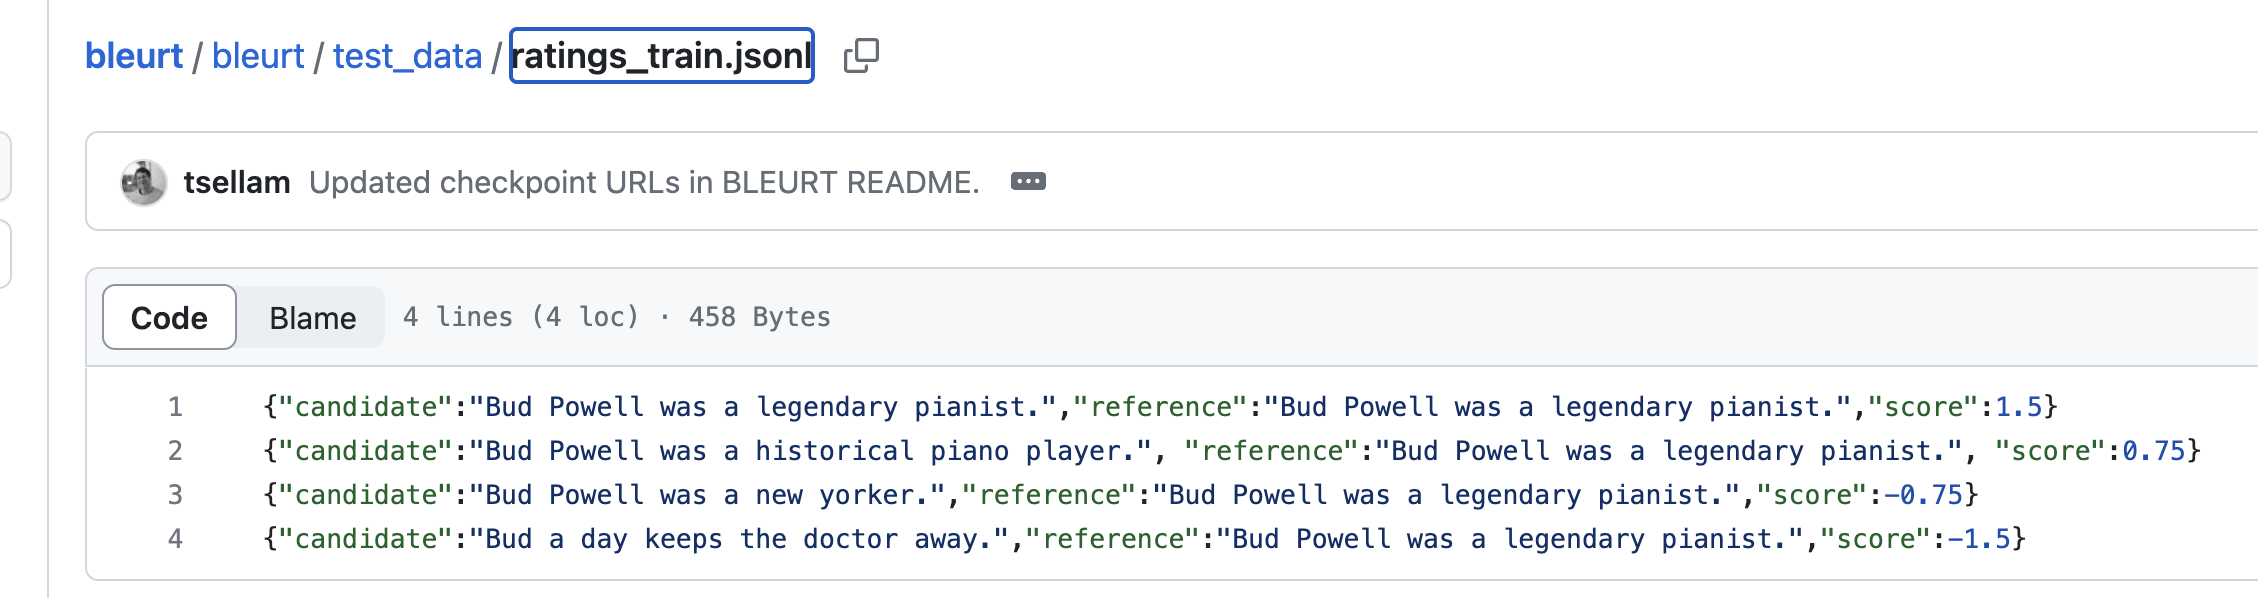

In [ ]:
#since bleurt expects scores within the same json file we need to concat witht the Y's
x_train, x_test = pd.concat([x_train, y_train], axis=1), pd.concat([x_test, y_test], axis=1)

In [ ]:
x_train.head()

,lp,src,mt,ref,system,annotators,domain,year,score
91737,en-de,Religious organizations and institutions shoul...,Religiöse Organisationen und Institutionen sol...,Für religiöse Organisationen und Einrichtungen...,Lan-Bridge,1,social,2022,-0.000000
52032,en-ru,PM's chief adviser underwent the experience la...,Главный советник премьер-министра прошел опыт ...,Старший советник премьер-министра испытал этот...,metricsystem4,1,news,2021,61.538462
129452,zh-en,餐厅只给我拿一袋，要装到袋中，天气冷,"[The restaurant only brought me a bag, which s...","The restaurant only gave me one bag of it, and...",AISP-SJTU,1,conversation,2022,-6.000000
132192,en-ru,Shiba Inu is the latest meme-crypto to go vira...,"[Shiba Inu - это новейший мем-крипто, который ...","Shiba Inu — последняя вирусная криптовалюта, к...",eTranslation,1,news,2022,-5.100000
10015,en-de,"But the austere kingdom, which forbids alcohol...","[Aber das strenge Königreich, das Alkohol verb...","Doch das strenge Königreich, das Alkohol verbi...",OPPO.1535,3,news,2020,-0.333333


In [ ]:
#rename to match the expected JSON formatting
x_train = x_train.rename(columns={"lp": "lp",
                   "src": "src",
                   "mt": "candidate",
                   "ref": "reference",
                   "system": "system",
                   "annotators": "annotators",
                   "domain": "domain",
                   "year": "year",
                   "score": "score"
                   })
x_test = x_test.rename(columns={"lp": "lp",
                   "src": "src",
                   "mt": "candidate",
                   "ref": "reference",
                   "system": "system",
                   "annotators": "annotators",
                   "domain": "domain",
                   "year": "year",
                   "score": "score"
                   })

In [ ]:
#filter to only the desired columns for JSON
x_train = x_train[['candidate','reference','score']]
x_test = x_test[['candidate','reference','score']]

In [ ]:
#lets confirm it worked and is ready to convert to JSON
x_train.head()

,candidate,reference,score
91737,Religiöse Organisationen und Institutionen sol...,Für religiöse Organisationen und Einrichtungen...,-0.000000
52032,Главный советник премьер-министра прошел опыт ...,Старший советник премьер-министра испытал этот...,61.538462
129452,"[The restaurant only brought me a bag, which s...","The restaurant only gave me one bag of it, and...",-6.000000
132192,"[Shiba Inu - это новейший мем-крипто, который ...","Shiba Inu — последняя вирусная криптовалюта, к...",-5.100000
10015,"[Aber das strenge Königreich, das Alkohol verb...","Doch das strenge Königreich, das Alkohol verbi...",-0.333333


In [ ]:
#we will try to only implement 1 row to see if it works
x_train[:1]

,candidate,reference,score
91737,Religiöse Organisationen und Institutionen sol...,Für religiöse Organisationen und Einrichtungen...,-0.0


In [ ]:
# Output in JSONL format into a file
import json
from json import loads, dumps
x_train_json = x_train[:1].to_json(orient="records")

#to do this I created a black file on the left in the foler titled 'x_train_jsonl.jsonl'
#might have to create this each time its ran
with open('x_train_jsonl.jsonl', 'w', encoding='utf-8') as f:
    json.dump(x_train_json, f, ensure_ascii=False, indent=4)


In [ ]:
#do the same with the test data
x_test_json = x_test[:1].to_json(orient="records")

with open('x_test_jsonl.jsonl', 'w', encoding='utf-8') as f:
    json.dump(x_test_json, f, ensure_ascii=False, indent=4)

#Fine Tuning BLEURT with Augmented data

In [ ]:
#install bleurt
import sys
!pip install --upgrade pip  # ensures that pip is current
!git clone https://github.com/google-research/bleurt.git
!pip install ./bleurt

fatal: destination path 'bleurt' already exists and is not an empty directory.
Processing ./bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456764 sha256=475ff2e7981f157a5cffa71608471e7c5182c9970e3bba62ae61f1a6a01c03a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8ebryq8/wheels/92/4f/fb/afa555fa27aa9e2c7958df797a62cc4e74f0f459cec9c4fa7c
Successfully built BLEURT
  Attempting uninstall: BLEURT
    Found existing installation: BLEURT 0.0.2
    Uninstalling BLEURT-0.0.2:
      Successfully uninstalled BLEURT-0.0.2


Per BLEURT documentation BLEURT will default to BERT-Tiny if no checkpoint is specified, which is very light but also very inaccurate (we recommend against using it)

I added the BLUERT-20 model in a folder in our [drive](https://drive.google.com/drive/folders/1kwU0nAFQa4G2wRqv5TL2nm8mXAJCc_CF?usp=drive_link)

In [ ]:
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip .
!unzip BLEURT-20.zip

--2023-07-23 22:59:50--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2140294207 (2.0G) [application/octet-stream]
Saving to: ‘BLEURT-20.zip’

BLEURT-20.zip       100%[===================>]   1.99G  31.6MB/s    in 62s     

2023-07-23 23:00:53 (32.8 MB/s) - ‘BLEURT-20.zip’ saved [2140294207/2140294207]

--2023-07-23 23:00:53--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-07-23 23:00:53--
Total wall clock time: 1m 2s
Downloaded: 1 files, 2.0G in 1m 2s (32.8 MB/s)
Archive:  BLEURT-20.zip
   creating: BLEURT-20/
  inflating: BLEURT-20/bert_config.json  
  inflating: BLEURT-20/saved_model.pb  
   creating: BLEURT-20/variables/
 

In [ ]:
!python -m bleurt.finetune \
  -init_bleurt_checkpoint=BLEURT-20 \
  -model_dir=bleurt \
  -train_set=x_train_json.jsonl \
  -dev_set=x_test_json.jsonl \
  -num_train_steps=500

2023-07-23 23:28:48.317549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 23:28:53.832875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:tensorflow:Dynamic seq length requested - disabling Eager Mode.
I0723 23:28:58.598826 132196264411136 finetune.py:111] Dynamic seq length requested - disabling Eager Mode.
INFO:tensorflow:Reading BLEURT parameters
I0723 23:28:58.599121 132196264411136 checkpoint.py:32] Reading BLEURT parameters
INFO:tensorflow:Reading paramter from BLEURT checkpoint: BLEURT-20
I0723 23:28:58.599199 132196264411136 checkpoint.py:35] Reading paramter from BLEURT checkpoint: BLEURT-20
INFO:tensorflow:Config file found, reading.
I0723 23:28:58.599327 132196264411136 checkpo